# Linear regression showing effects of sex, age, and sex*age on ICD connectivity

## A. Import Statements

In [1]:
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.stats.api as sms
from statsmodels.tools.eval_measures import rmse
from scipy import stats
from statsmodels.graphics.api import abline_plot
import statistics as stats

# import h2o
# from h2o.estimators.glm import H2OGeneralizedLinearEstimator
# h2o.init()
# import warnings
# warnings.filterwarnings('ignore')

# /////////////////////////////////////////////////////////////////////////////////////////////////

## B. RAVLT-Learning (Sum of trials 1-5) ICD GLM
### Load in demographic and ICD results of each subject

In [2]:
ravlt_icd_data = pd.read_csv('data/connectivity_ravlt.csv',sep = ',',skip_blank_lines = True)

master_icd_data = pd.DataFrame(columns = ['subj_id','sex','age','RAVLT Sum of Trials 1-5','Left PCC:Left AG Connectivity','Left PCC:Left PHG Connectivity'])
master_icd_data['subj_id'] = ravlt_icd_data['src_subject_id']
master_icd_data['sex'] = ravlt_icd_data['sex']
master_icd_data['age'] = ravlt_icd_data['interview_age']/12
master_icd_data['RAVLT Sum of Trials 1-5'] = ravlt_icd_data['ravlt_L']
master_icd_data['Left PCC:Left AG Connectivity'] = ravlt_icd_data['ROI28_Langulargyrus']
master_icd_data['Left PCC:Left PHG Connectivity'] = ravlt_icd_data['ROI9_Lmesialtemporal']

master_icd_data.set_index('subj_id',inplace=True)
master_icd_data = pd.get_dummies(master_icd_data, columns = ['sex'])
master_icd_data = master_icd_data.drop('sex_M', axis = 1)

master_icd_data['sex*age'] = master_icd_data['sex_F']*master_icd_data['age']

master_icd_data = sm.add_constant(master_icd_data)

master_icd_data = master_icd_data.dropna()
# master_icd_data = master_icd_data.drop(labels=['HCA9868920'], axis = 0)

# master_icd_data.head(10)


### Data exploration

In [3]:
master_icd_data.head()

,const,age,RAVLT Sum of Trials 1-5,Left PCC:Left AG Connectivity,Left PCC:Left PHG Connectivity,sex_F,sex*age
subj_id,,,,,,,
HCA6030645,1.0,45.333333,47.0,0.1125,0.0090,1,45.333333
HCA6051047,1.0,60.416667,45.0,0.0740,0.0747,1,60.416667
HCA6053758,1.0,36.416667,45.0,0.0219,0.0034,1,36.416667
HCA6054457,1.0,62.500000,47.0,0.1131,0.0134,0,0.000000
HCA6075263,1.0,63.916667,42.0,0.0230,-0.0084,0,0.000000


In [4]:
y = master_icd_data[['RAVLT Sum of Trials 1-5']]
# y['RAVLT Sum of Trials 1-5'].value_counts()
# discrete integers, 
# if the range is fixed Multinomial
# if the range goes from 0 to infinity, Poisson?
# https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html

stats.mean(y['RAVLT Sum of Trials 1-5'])

46.60314341846758

In [5]:
np.var(y['RAVLT Sum of Trials 1-5'])

106.00360505015806

## i. GLM for RAVLT vs. Left PCC:Left AG Connectivity

### i-a. Gamma family - GLM for RAVLT vs. Left PCC:Left AG Connectivity

In [6]:
cols = ['Left PCC:Left AG Connectivity','sex_F','age','sex*age','const']
ravlt_L_x_1 = master_icd_data[cols]
ravlt_L_y_1 = master_icd_data[['RAVLT Sum of Trials 1-5']]

ravlt_L_glm_1 = sm.GLM(ravlt_L_y_1, ravlt_L_x_1, family=sm.families.Gamma(sm.families.links.log())).fit()
ravlt_L_glm_1.summary()

/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:777: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1767: RuntimeWarning: invalid value encountered in double_scalars
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                    
===================================================================================
Dep. Variable:     RAVLT Sum of Trials 1-5   No. Observations:                  509
Model:                                 GLM   Df Residuals:                      504
Model Family:                        Gamma   Df Model:                            4
Link Function:                         log   Scale:                        0.044062
Method:                               IRLS   Log-Likelihood:                    inf
Date:                     Tue, 01 Nov 2022   Deviance:                       92.133
Time:                             15:18:11   Pearson chi2:                     22.2
No. Iterations:                          9   Pseudo R-squ. (CS):                nan
Covariance Type:                 nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Left PCC:Left AG Connectivity     0.0759      0.190      0.400      0.689      -0.296       0.448
sex_F                            -0.0382      0.081     -0.471      0.638      -0.197       0.121
age                              -0.0063      0.001     -5.947      0.000      -0.008      -0.004
sex*age                           0.0022      0.001      1.569      0.117      -0.001       0.005
const                             4.1450      0.065     63.536      0.000       4.017       4.273
=================================================================================================
"""

### i-b. Poisson family - GLM for RAVLT vs. Left PCC:Left AG Connectivity (WW)

In [7]:
# same covariates, Posisson
# tutorial for Poisson https://timeseriesreasoning.com/contents/poisson-regression-model/
ravlt_L_glm_1 = sm.GLM(ravlt_L_y_1, ravlt_L_x_1, family=sm.families.Poisson()).fit()
# maybe check other links?
ravlt_L_glm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                    
===================================================================================
Dep. Variable:     RAVLT Sum of Trials 1-5   No. Observations:                  509
Model:                                 GLM   Df Residuals:                      504
Model Family:                      Poisson   Df Model:                            4
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -1968.4
Date:                     Tue, 01 Nov 2022   Deviance:                       1061.4
Time:                             15:18:11   Pearson chi2:                 1.01e+03
No. Iterations:                          4   Pseudo R-squ. (CS):             0.2801
Covariance Type:                 nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Left PCC:Left AG Connectivity     0.1129      0.131      0.860      0.390      -0.145       0.370
sex_F                            -0.0413      0.057     -0.726      0.468      -0.153       0.070
age                              -0.0063      0.001     -8.178      0.000      -0.008      -0.005
sex*age                           0.0022      0.001      2.237      0.025       0.000       0.004
const                             4.1413      0.046     89.505      0.000       4.051       4.232
=================================================================================================
"""

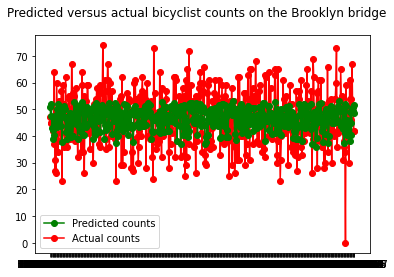

In [8]:
poisson_predictions = ravlt_L_glm_1.get_prediction(ravlt_L_x_1)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()

predicted_counts=predictions_summary_frame['mean']
actual_counts = ravlt_L_y_1['RAVLT Sum of Trials 1-5']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
actual, = plt.plot(ravlt_L_x_1.index, actual_counts, 'ro-', label='Actual counts')
predicted, = plt.plot(ravlt_L_x_1.index, predicted_counts, 'go-', label='Predicted counts')
plt.legend(handles=[predicted, actual])
plt.show()

<Figure size 432x288 with 0 Axes>

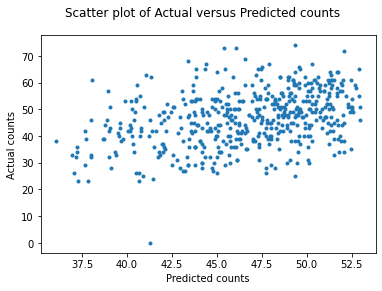

In [9]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

In [10]:
ravlt_L_glm_1.aic

3946.74391330217

In [11]:
ravlt_L_glm_1.bic

/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1799: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


-2079.7960661867155

### i-c. NegativeBinomial family - GLM for RAVLT vs. Left PCC:Left AG Connectivity 

In [12]:
# same covariates, multinomial
ravlt_L_glm_1 = sm.GLM(ravlt_L_y_1, ravlt_L_x_1, family=sm.families.NegativeBinomial()).fit()
ravlt_L_glm_1.summary()

# ravlt_L_y_1_temp = ravlt_L_y_1.asfactor()

# train, valid = ravlt_L_y_1.split_frame(ratios = [.8])

# ravlt_L_glm_1 = H2OGeneralizedLinearEstimator(family = 'multinomial')
# ravlt_L_glm_1.train(x = ravlt_L_x_1, y = ravlt_L_y_1, training_frame = train, validation_frame = valid)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                    
===================================================================================
Dep. Variable:     RAVLT Sum of Trials 1-5   No. Observations:                  509
Model:                                 GLM   Df Residuals:                      504
Model Family:             NegativeBinomial   Df Model:                            4
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -2468.0
Date:                     Tue, 01 Nov 2022   Deviance:                       29.030
Time:                             15:18:17   Pearson chi2:                     21.7
No. Iterations:                          4   Pseudo R-squ. (CS):           0.007030
Covariance Type:                 nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Left PCC:Left AG Connectivity     0.0767      0.914      0.084      0.933      -1.715       1.868
sex_F                            -0.0382      0.391     -0.098      0.922      -0.804       0.727
age                              -0.0063      0.005     -1.234      0.217      -0.016       0.004
sex*age                           0.0022      0.007      0.326      0.745      -0.011       0.015
const                             4.1449      0.314     13.190      0.000       3.529       4.761
=================================================================================================
"""

In [13]:
ravlt_L_glm_1.aic

4946.071817328921

In [14]:
ravlt_L_glm_1.bic

/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1799: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


-3112.1239880555845

## ii. GLM for RAVLT vs. Left PCC:Left AG Connectivity (w/o sex and sex*age)

### ii-a. Gamma family - GLM for RAVLT vs. Left PCC:Left AG Connectivity (w/o sex and sex*age)

In [15]:
cols = ['Left PCC:Left AG Connectivity','age','const']
ravlt_L_x_1_1 = master_icd_data[cols]
ravlt_L_y_1_1 = master_icd_data[['RAVLT Sum of Trials 1-5']]

ravlt_L_glm_1_1 = sm.GLM(ravlt_L_y_1_1, ravlt_L_x_1_1, family=sm.families.Gamma(sm.families.links.log())).fit()
ravlt_L_glm_1_1.summary()

/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:777: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1767: RuntimeWarning: invalid value encountered in double_scalars
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                    
===================================================================================
Dep. Variable:     RAVLT Sum of Trials 1-5   No. Observations:                  509
Model:                                 GLM   Df Residuals:                      506
Model Family:                        Gamma   Df Model:                            2
Link Function:                         log   Scale:                        0.045150
Method:                               IRLS   Log-Likelihood:                    inf
Date:                     Tue, 01 Nov 2022   Deviance:                       92.903
Time:                             15:18:17   Pearson chi2:                     22.8
No. Iterations:                          9   Pseudo R-squ. (CS):                nan
Covariance Type:                 nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Left PCC:Left AG Connectivity     0.3268      0.183      1.781      0.075      -0.033       0.686
age                              -0.0050      0.001     -7.375      0.000      -0.006      -0.004
const                             4.1016      0.044     92.812      0.000       4.015       4.188
=================================================================================================
"""

### ii-b. Poisson family - GLM for RAVLT vs. Left PCC:Left AG Connectivity (w/o sex and sex*age)

In [16]:
# same covariates, Posisson
# tutorial for Poisson https://timeseriesreasoning.com/contents/poisson-regression-model/
ravlt_L_glm_1_1 = sm.GLM(ravlt_L_y_1_1, ravlt_L_x_1_1, family=sm.families.Poisson()).fit()
# maybe check other links?
ravlt_L_glm_1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                    
===================================================================================
Dep. Variable:     RAVLT Sum of Trials 1-5   No. Observations:                  509
Model:                                 GLM   Df Residuals:                      506
Model Family:                      Poisson   Df Model:                            2
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -1988.4
Date:                     Tue, 01 Nov 2022   Deviance:                       1101.4
Time:                             15:18:17   Pearson chi2:                 1.05e+03
No. Iterations:                          4   Pseudo R-squ. (CS):             0.2211
Covariance Type:                 nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Left PCC:Left AG Connectivity     0.3455      0.125      2.754      0.006       0.100       0.591
age                              -0.0050      0.000    -10.493      0.000      -0.006      -0.004
const                             4.0988      0.030    134.553      0.000       4.039       4.158
=================================================================================================
"""

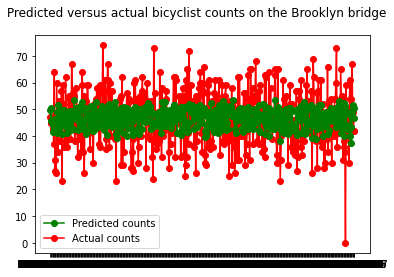

In [17]:
poisson_predictions = ravlt_L_glm_1_1.get_prediction(ravlt_L_x_1_1)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()

predicted_counts=predictions_summary_frame['mean']
actual_counts = ravlt_L_y_1_1['RAVLT Sum of Trials 1-5']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
actual, = plt.plot(ravlt_L_x_1_1.index, actual_counts, 'ro-', label='Actual counts')
predicted, = plt.plot(ravlt_L_x_1_1.index, predicted_counts, 'go-', label='Predicted counts')
plt.legend(handles=[predicted, actual])
plt.show()

<Figure size 432x288 with 0 Axes>

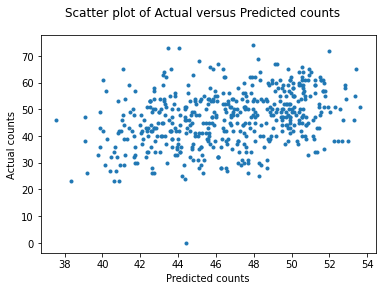

In [18]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

### ii-c. NegativeBinomial family - GLM for RAVLT vs. Left PCC:Left AG Connectivity (w/o sex and sex*age)

In [19]:
# same covariates, multinomial
ravlt_L_glm_1_1 = sm.GLM(ravlt_L_y_1_1, ravlt_L_x_1_1, family=sm.families.NegativeBinomial()).fit()
ravlt_L_glm_1_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                    
===================================================================================
Dep. Variable:     RAVLT Sum of Trials 1-5   No. Observations:                  509
Model:                                 GLM   Df Residuals:                      506
Model Family:             NegativeBinomial   Df Model:                            2
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -2468.5
Date:                     Tue, 01 Nov 2022   Deviance:                       29.929
Time:                             15:18:23   Pearson chi2:                     22.4
No. Iterations:                          4   Pseudo R-squ. (CS):           0.005274
Covariance Type:                 nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Left PCC:Left AG Connectivity     0.3272      0.873      0.375      0.708      -1.383       2.038
age                              -0.0050      0.003     -1.550      0.121      -0.011       0.001
const                             4.1015      0.210     19.512      0.000       3.689       4.513
=================================================================================================
"""

## iii. GLM for RAVLT vs. Left PCC:Left PHG Connectivity

### iii-a. Gamma family - GLM for RAVLT vs. Left PCC:Left PHG Connectivity

In [20]:
cols = ['Left PCC:Left PHG Connectivity','sex_F','age','sex*age','const']
ravlt_L_x_2 = master_icd_data[cols]
ravlt_L_y_2 = master_icd_data[['RAVLT Sum of Trials 1-5']]

ravlt_L_glm_2 = sm.GLM(ravlt_L_y_2, ravlt_L_x_2, family=sm.families.Gamma(sm.families.links.log())).fit()
ravlt_L_glm_2.summary()

/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:777: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1767: RuntimeWarning: invalid value encountered in double_scalars
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                    
===================================================================================
Dep. Variable:     RAVLT Sum of Trials 1-5   No. Observations:                  509
Model:                                 GLM   Df Residuals:                      504
Model Family:                        Gamma   Df Model:                            4
Link Function:                         log   Scale:                        0.044063
Method:                               IRLS   Log-Likelihood:                    inf
Date:                     Tue, 01 Nov 2022   Deviance:                       92.132
Time:                             15:18:23   Pearson chi2:                     22.2
No. Iterations:                          8   Pseudo R-squ. (CS):                nan
Covariance Type:                 nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Left PCC:Left PHG Connectivity     0.1578      0.373      0.423      0.672      -0.573       0.889
sex_F                             -0.0385      0.081     -0.475      0.635      -0.197       0.120
age                               -0.0063      0.001     -5.965      0.000      -0.008      -0.004
sex*age                            0.0021      0.001      1.567      0.117      -0.001       0.005
const                              4.1480      0.064     64.976      0.000       4.023       4.273
==================================================================================================
"""

### iii-b. Poisson family - GLM for RAVLT vs. Left PCC:Left PHG Connectivity

In [21]:
# same covariates, Posisson
# tutorial for Poisson https://timeseriesreasoning.com/contents/poisson-regression-model/
ravlt_L_glm_2 = sm.GLM(ravlt_L_y_2, ravlt_L_x_2, family=sm.families.Poisson()).fit()
# maybe check other links?
ravlt_L_glm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                    
===================================================================================
Dep. Variable:     RAVLT Sum of Trials 1-5   No. Observations:                  509
Model:                                 GLM   Df Residuals:                      504
Model Family:                      Poisson   Df Model:                            4
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -1968.5
Date:                     Tue, 01 Nov 2022   Deviance:                       1061.7
Time:                             15:18:23   Pearson chi2:                 1.01e+03
No. Iterations:                          4   Pseudo R-squ. (CS):             0.2796
Covariance Type:                 nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Left PCC:Left PHG Connectivity     0.1655      0.257      0.644      0.520      -0.338       0.669
sex_F                             -0.0406      0.057     -0.714      0.475      -0.152       0.071
age                               -0.0063      0.001     -8.212      0.000      -0.008      -0.005
sex*age                            0.0022      0.001      2.234      0.025       0.000       0.004
const                              4.1469      0.045     91.497      0.000       4.058       4.236
==================================================================================================
"""

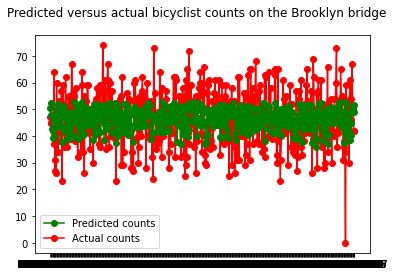

In [22]:
poisson_predictions = ravlt_L_glm_2.get_prediction(ravlt_L_x_2)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()

predicted_counts=predictions_summary_frame['mean']
actual_counts = ravlt_L_y_2['RAVLT Sum of Trials 1-5']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
actual, = plt.plot(ravlt_L_x_2.index, actual_counts, 'ro-', label='Actual counts')
predicted, = plt.plot(ravlt_L_x_2.index, predicted_counts, 'go-', label='Predicted counts')
plt.legend(handles=[predicted, actual])
plt.show()

<Figure size 432x288 with 0 Axes>

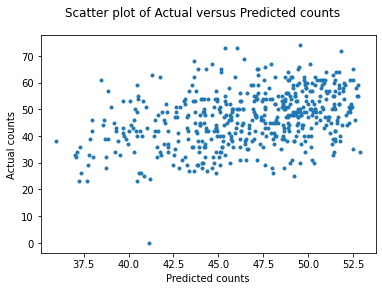

In [23]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

### iii-c. NegativeBinomial family - GLM for RAVLT vs. Left PCC:Left PHG Connectivity 

In [24]:
# same covariates, multinomial
ravlt_L_glm_2 = sm.GLM(ravlt_L_y_2, ravlt_L_x_2, family=sm.families.NegativeBinomial()).fit()
ravlt_L_glm_2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                    
===================================================================================
Dep. Variable:     RAVLT Sum of Trials 1-5   No. Observations:                  509
Model:                                 GLM   Df Residuals:                      504
Model Family:             NegativeBinomial   Df Model:                            4
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -2468.0
Date:                     Tue, 01 Nov 2022   Deviance:                       29.029
Time:                             15:18:29   Pearson chi2:                     21.7
No. Iterations:                          4   Pseudo R-squ. (CS):           0.007031
Covariance Type:                 nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Left PCC:Left PHG Connectivity     0.1579      1.795      0.088      0.930      -3.360       3.676
sex_F                             -0.0385      0.391     -0.099      0.921      -0.804       0.727
age                               -0.0063      0.005     -1.238      0.216      -0.016       0.004
sex*age                            0.0022      0.007      0.325      0.745      -0.011       0.015
const                              4.1480      0.308     13.489      0.000       3.545       4.751
==================================================================================================
"""

## iv. GLM for RAVLT vs. Left PCC:Left PHG Connectivity (w/o sex and sex*age)

### iv-a. Gamma family - GLM for RAVLT vs. Left PCC:Left PHG Connectivity (w/o sex and sex*age)

In [25]:
cols = ['Left PCC:Left PHG Connectivity','age','const']
ravlt_L_x_2_1 = master_icd_data[cols]
ravlt_L_y_2_1 = master_icd_data[['RAVLT Sum of Trials 1-5']]

ravlt_L_glm_2_1 = sm.GLM(ravlt_L_y_2_1, ravlt_L_x_2_1, family=sm.families.Gamma(sm.families.links.log())).fit()
ravlt_L_glm_2_1.summary()

/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:777: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1767: RuntimeWarning: invalid value encountered in double_scalars
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                    
===================================================================================
Dep. Variable:     RAVLT Sum of Trials 1-5   No. Observations:                  509
Model:                                 GLM   Df Residuals:                      506
Model Family:                        Gamma   Df Model:                            2
Link Function:                         log   Scale:                        0.045153
Method:                               IRLS   Log-Likelihood:                    inf
Date:                     Tue, 01 Nov 2022   Deviance:                       92.882
Time:                             15:18:29   Pearson chi2:                     22.8
No. Iterations:                          7   Pseudo R-squ. (CS):                nan
Covariance Type:                 nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Left PCC:Left PHG Connectivity     0.6880      0.356      1.933      0.053      -0.010       1.386
age                               -0.0051      0.001     -7.470      0.000      -0.006      -0.004
const                              4.1131      0.042     98.548      0.000       4.031       4.195
==================================================================================================
"""

### iv-b. Poisson family - GLM for RAVLT vs. Left PCC:Left PHG Connectivity (w/o sex and sex*age)

In [26]:
# same covariates, Posisson
# tutorial for Poisson https://timeseriesreasoning.com/contents/poisson-regression-model/
ravlt_L_glm_2_1 = sm.GLM(ravlt_L_y_2_1, ravlt_L_x_2_1, family=sm.families.Poisson()).fit()
# maybe check other links?
ravlt_L_glm_2_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                    
===================================================================================
Dep. Variable:     RAVLT Sum of Trials 1-5   No. Observations:                  509
Model:                                 GLM   Df Residuals:                      506
Model Family:                      Poisson   Df Model:                            2
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -1988.3
Date:                     Tue, 01 Nov 2022   Deviance:                       1101.3
Time:                             15:18:29   Pearson chi2:                 1.05e+03
No. Iterations:                          4   Pseudo R-squ. (CS):             0.2213
Covariance Type:                 nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Left PCC:Left PHG Connectivity     0.6747      0.243      2.780      0.005       0.199       1.150
age                               -0.0051      0.000    -10.612      0.000      -0.006      -0.004
const                              4.1117      0.029    143.081      0.000       4.055       4.168
==================================================================================================
"""

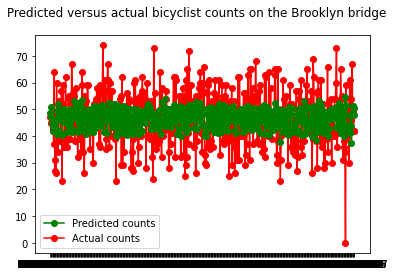

In [27]:
poisson_predictions = ravlt_L_glm_2_1.get_prediction(ravlt_L_x_2_1)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()

predicted_counts=predictions_summary_frame['mean']
actual_counts = ravlt_L_y_2_1['RAVLT Sum of Trials 1-5']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
actual, = plt.plot(ravlt_L_x_2_1.index, actual_counts, 'ro-', label='Actual counts')
predicted, = plt.plot(ravlt_L_x_2_1.index, predicted_counts, 'go-', label='Predicted counts')
plt.legend(handles=[predicted, actual])
plt.show()

<Figure size 432x288 with 0 Axes>

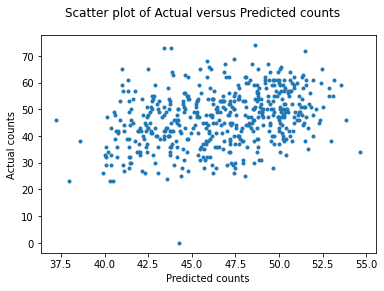

In [28]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

### iv-c. NegativeBinomial family - GLM for RAVLT vs. Left PCC:Left PHG Connectivity (w/o sex and sex*age)

In [29]:
# same covariates, multinomial
ravlt_L_glm_2_1 = sm.GLM(ravlt_L_y_2_1, ravlt_L_x_2_1, family=sm.families.NegativeBinomial()).fit()
ravlt_L_glm_2_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                    
===================================================================================
Dep. Variable:     RAVLT Sum of Trials 1-5   No. Observations:                  509
Model:                                 GLM   Df Residuals:                      506
Model Family:             NegativeBinomial   Df Model:                            2
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -2468.5
Date:                     Tue, 01 Nov 2022   Deviance:                       29.905
Time:                             15:18:35   Pearson chi2:                     22.4
No. Iterations:                          4   Pseudo R-squ. (CS):           0.005321
Covariance Type:                 nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Left PCC:Left PHG Connectivity     0.6877      1.693      0.406      0.685      -2.630       4.006
age                               -0.0051      0.003     -1.570      0.116      -0.011       0.001
const                              4.1131      0.199     20.719      0.000       3.724       4.502
==================================================================================================
"""

# /////////////////////////////////////////////////////////////////////////////////////////////////

## C. Neuroticism ICD GLM
### Load in demographic and ICD results of each subject

In [30]:
neuro_icd_data = pd.read_csv('data/connectivity_personality_emotion.csv',sep = ',',skip_blank_lines = True)

master_n_icd_data = pd.DataFrame(columns = ['subj_id','sex','age','Neuroticism','Left PCC:Right STS Connectivity','Left PCC:Left Insula Connectivity'])
master_n_icd_data['subj_id'] = neuro_icd_data['src_subject_id']
master_n_icd_data['sex'] = neuro_icd_data['sex']
master_n_icd_data['age'] = neuro_icd_data['interview_age']/12
master_n_icd_data['Neuroticism'] = neuro_icd_data['Neuroticism']
master_n_icd_data['Left PCC:Right STS Connectivity'] = neuro_icd_data['ROI17_Rsuperiortemporal']
master_n_icd_data['Left PCC:Left Insula Connectivity'] = neuro_icd_data['ROI7_Linsula']

master_n_icd_data.set_index('subj_id',inplace=True)
master_n_icd_data = pd.get_dummies(master_n_icd_data, columns = ['sex'])
master_n_icd_data = master_n_icd_data.drop('sex_M', axis = 1)

master_n_icd_data['sex*age'] = master_n_icd_data['sex_F']*master_n_icd_data['age']

master_n_icd_data = sm.add_constant(master_n_icd_data)

master_n_icd_data = master_n_icd_data.dropna()

# master_n_icd_data.tail(60)


### Data exploration

In [31]:
y = master_n_icd_data[['Neuroticism']]
y['Neuroticism'].value_counts()
# mul## i. GLM for RAVLT vs. Left PCC:Left AG Connectivitytiple class, multinomial or Poisson as well

10    32
16    32
19    28
13    26
12    26
14    23
15    23
17    23
8     22
7     19
6     18
9     18
18    17
11    17
20    15
25    12
22    12
21    11
4     11
2     10
5      9
24     9
28     8
23     8
26     8
27     8
32     5
29     5
30     5
1      4
0      3
3      3
31     2
40     1
34     1
47     1
35     1
37     1
33     1
Name: Neuroticism, dtype: int64

## i. GLM for Neuroticism vs. Left PCC:Right STS Connectivity

### i-a. Gamma family - GLM for Neuroticism vs. Left PCC:Right STS Connectivity

In [32]:
cols = ['Left PCC:Right STS Connectivity','sex_F','age','sex*age','const']
neon_x_1 = master_n_icd_data[cols]
neon_y_1 = master_n_icd_data[['Neuroticism']]

neon_glm_1 = sm.GLM(neon_y_1, neon_x_1, family=sm.families.Gamma(sm.families.links.log())).fit()
neon_glm_1.summary()

/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:777: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1767: RuntimeWarning: invalid value encountered in double_scalars
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            Neuroticism   No. Observations:                  478
Model:                            GLM   Df Residuals:                      473
Model Family:                   Gamma   Df Model:                            4
Link Function:                    log   Scale:                         0.23421
Method:                          IRLS   Log-Likelihood:                    inf
Date:                Tue, 01 Nov 2022   Deviance:                       346.10
Time:                        15:18:36   Pearson chi2:                     111.
No. Iterations:                    10   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Left PCC:Right STS Connectivity    -1.2071      0.512     -2.357      0.018      -2.211      -0.203
sex_F                              -0.7006      0.195     -3.586      0.000      -1.084      -0.318
age                                -0.0155      0.003     -6.002      0.000      -0.021      -0.010
sex*age                             0.0127      0.003      3.841      0.000       0.006       0.019
const                               3.5668      0.154     23.233      0.000       3.266       3.868
===================================================================================================
"""

### i-b. Poisson family - GLM for Neuroticism vs. Left PCC:Right STS Connectivity

In [33]:
neon_glm_1 = sm.GLM(neon_y_1, neon_x_1, family=sm.families.Poisson()).fit()
neon_glm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            Neuroticism   No. Observations:                  478
Model:                            GLM   Df Residuals:                      473
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1916.7
Date:                Tue, 01 Nov 2022   Deviance:                       1737.1
Time:                        15:18:36   Pearson chi2:                 1.64e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2646
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Left PCC:Right STS Connectivity    -1.1789      0.274     -4.300      0.000      -1.716      -0.642
sex_F                              -0.6643      0.103     -6.435      0.000      -0.867      -0.462
age                                -0.0151      0.001    -10.541      0.000      -0.018      -0.012
sex*age                             0.0120      0.002      6.667      0.000       0.008       0.016
const                               3.5429      0.081     43.683      0.000       3.384       3.702
===================================================================================================
"""

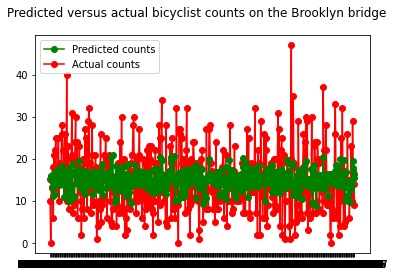

In [34]:
poisson_predictions = neon_glm_1.get_prediction(neon_x_1)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()

predicted_counts=predictions_summary_frame['mean']
actual_counts = neon_y_1['Neuroticism']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
actual, = plt.plot(neon_x_1.index, actual_counts, 'ro-', label='Actual counts')
predicted, = plt.plot(neon_x_1.index, predicted_counts, 'go-', label='Predicted counts')
plt.legend(handles=[predicted, actual])
plt.show()

<Figure size 432x288 with 0 Axes>

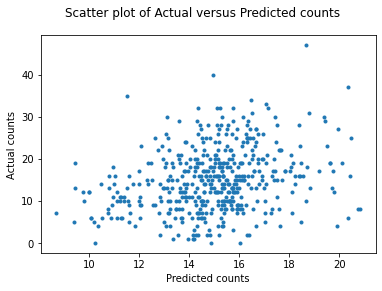

In [35]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

### i-c. NegativeBinomial family - GLM for Neuroticism vs. Left PCC:Right STS Connectivity

In [36]:
neon_glm_1 = sm.GLM(neon_y_1, neon_x_1, family=sm.families.NegativeBinomial()).fit()
neon_glm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            Neuroticism   No. Observations:                  478
Model:                            GLM   Df Residuals:                      473
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1782.0
Date:                Tue, 01 Nov 2022   Deviance:                       138.79
Time:                        15:18:41   Pearson chi2:                     104.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02000
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Left PCC:Right STS Connectivity    -1.2069      1.094     -1.103      0.270      -3.351       0.937
sex_F                              -0.6985      0.417     -1.675      0.094      -1.516       0.119
age                                -0.0155      0.006     -2.797      0.005      -0.026      -0.005
sex*age                             0.0126      0.007      1.790      0.073      -0.001       0.026
const                               3.5654      0.328     10.875      0.000       2.923       4.208
===================================================================================================
"""

## ii. GLM for Neuroticism vs. Left PCC:Left Insula Connectivity

### ii-a. Gamma family - GLM for Neuroticism vs. Left PCC:Left Insula Connectivity

In [37]:
cols = ['Left PCC:Left Insula Connectivity','sex_F','age','sex*age','const']
neon_x_2 = master_n_icd_data[cols]
neon_y_2 = master_n_icd_data[['Neuroticism']]

neon_glm_2 = sm.GLM(neon_y_2, neon_x_2, family=sm.families.Gamma(sm.families.links.log())).fit()
neon_glm_2.summary()

/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:777: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1767: RuntimeWarning: invalid value encountered in double_scalars
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            Neuroticism   No. Observations:                  478
Model:                            GLM   Df Residuals:                      473
Model Family:                   Gamma   Df Model:                            4
Link Function:                    log   Scale:                         0.23596
Method:                          IRLS   Log-Likelihood:                    inf
Date:                Tue, 01 Nov 2022   Deviance:                       347.40
Time:                        15:18:41   Pearson chi2:                     112.
No. Iterations:                    10   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Left PCC:Left Insula Connectivity    -0.9810      1.143     -0.858      0.391      -3.222       1.260
sex_F                                -0.6458      0.195     -3.306      0.001      -1.029      -0.263
age                                  -0.0159      0.003     -6.053      0.000      -0.021      -0.011
sex*age                               0.0124      0.003      3.750      0.000       0.006       0.019
const                                 3.5907      0.159     22.605      0.000       3.279       3.902
=====================================================================================================
"""

### ii-b. Poisson family - GLM for Neuroticism vs. Left PCC:Right STS Connectivity

In [38]:
neon_glm_2 = sm.GLM(neon_y_2, neon_x_2, family=sm.families.Poisson()).fit()
neon_glm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            Neuroticism   No. Observations:                  478
Model:                            GLM   Df Residuals:                      473
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1924.4
Date:                Tue, 01 Nov 2022   Deviance:                       1752.5
Time:                        15:18:41   Pearson chi2:                 1.65e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2404
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Left PCC:Left Insula Connectivity    -1.0660      0.605     -1.763      0.078      -2.251       0.119
sex_F                                -0.6209      0.103     -6.028      0.000      -0.823      -0.419
age                                  -0.0156      0.001    -10.786      0.000      -0.018      -0.013
sex*age                               0.0120      0.002      6.655      0.000       0.008       0.016
const                                 3.5748      0.083     42.842      0.000       3.411       3.738
=====================================================================================================
"""

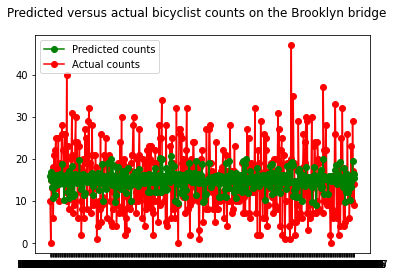

In [39]:
poisson_predictions = neon_glm_2.get_prediction(neon_x_2)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()

predicted_counts=predictions_summary_frame['mean']
actual_counts = neon_y_2['Neuroticism']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
actual, = plt.plot(neon_x_2.index, actual_counts, 'ro-', label='Actual counts')
predicted, = plt.plot(neon_x_2.index, predicted_counts, 'go-', label='Predicted counts')
plt.legend(handles=[predicted, actual])
plt.show()

<Figure size 432x288 with 0 Axes>

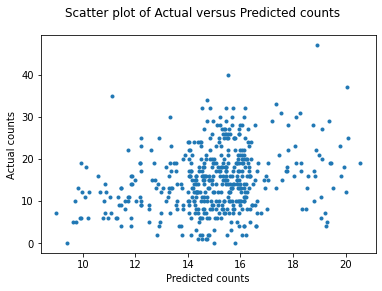

In [40]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

### ii-c. NegativeBinomial family - GLM for Neuroticism vs. Left PCC:Right STS Connectivity

In [41]:
neon_glm_2 = sm.GLM(neon_y_2, neon_x_2, family=sm.families.NegativeBinomial()).fit()
neon_glm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            Neuroticism   No. Observations:                  478
Model:                            GLM   Df Residuals:                      473
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1782.6
Date:                Tue, 01 Nov 2022   Deviance:                       139.84
Time:                        15:18:46   Pearson chi2:                     104.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01786
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Left PCC:Left Insula Connectivity    -0.9839      2.431     -0.405      0.686      -5.748       3.781
sex_F                                -0.6439      0.415     -1.550      0.121      -1.458       0.170
age                                  -0.0158      0.006     -2.832      0.005      -0.027      -0.005
sex*age                               0.0124      0.007      1.755      0.079      -0.001       0.026
const                                 3.5893      0.338     10.623      0.000       2.927       4.252
=====================================================================================================
"""

# /////////////////////////////////////////////////////////////////////////////////////////////////

## D. RAVLT-Immediate Recall (Trial 6) ICD GLM
### Load in demographic and ICD results of each subject

In [42]:
ravlt_IR_icd_data = pd.read_csv('data/connectivity_ravlt.csv',sep = ',',skip_blank_lines = True)

master_IR_icd_data = pd.DataFrame(columns = ['subj_id','sex','age','RAVLT Immediate Recall','Left PCC:Left AG Connectivity','Left PCC:Left PHG Connectivity'])
master_IR_icd_data['subj_id'] = ravlt_IR_icd_data['src_subject_id']
master_IR_icd_data['sex'] = ravlt_IR_icd_data['sex']
master_IR_icd_data['age'] = ravlt_IR_icd_data['interview_age']/12
master_IR_icd_data['RAVLT Immediate Recall'] = ravlt_IR_icd_data['trial6']
master_IR_icd_data['Left PCC:Left AG Connectivity'] = ravlt_IR_icd_data['ROI28_Langulargyrus']
master_IR_icd_data['Left PCC:Left PHG Connectivity'] = ravlt_IR_icd_data['ROI9_Lmesialtemporal']

master_IR_icd_data.set_index('subj_id',inplace=True)
master_IR_icd_data = pd.get_dummies(master_IR_icd_data, columns = ['sex'])
master_IR_icd_data = master_IR_icd_data.drop('sex_M', axis = 1)

master_IR_icd_data['sex*age'] = master_IR_icd_data['sex_F']*master_IR_icd_data['age']

master_IR_icd_data = sm.add_constant(master_IR_icd_data)

master_IR_icd_data = master_IR_icd_data.dropna()
# master_IR_icd_data = master_IR_icd_data.drop(labels=['HCA9868920'], axis = 0)

# master_IR_icd_data.head(10)


### Data exploration

In [43]:
master_IR_icd_data.head()

,const,age,RAVLT Immediate Recall,Left PCC:Left AG Connectivity,Left PCC:Left PHG Connectivity,sex_F,sex*age
subj_id,,,,,,,
HCA6030645,1.0,45.333333,9.0,0.1125,0.0090,1,45.333333
HCA6051047,1.0,60.416667,6.0,0.0740,0.0747,1,60.416667
HCA6053758,1.0,36.416667,11.0,0.0219,0.0034,1,36.416667
HCA6054457,1.0,62.500000,11.0,0.1131,0.0134,0,0.000000
HCA6075263,1.0,63.916667,9.0,0.0230,-0.0084,0,0.000000


## i. GLM for RAVLT vs. Left PCC:Left AG Connectivity

### i-a. Gamma family - GLM for RAVLT vs. Left PCC:Left AG Connectivity

In [44]:
cols = ['Left PCC:Left AG Connectivity','sex_F','age','sex*age','const']
ravlt_IR_x_1 = master_IR_icd_data[cols]
ravlt_IR_y_1 = master_IR_icd_data[['RAVLT Immediate Recall']]

ravlt_IR_glm_1 = sm.GLM(ravlt_IR_y_1, ravlt_IR_x_1, family=sm.families.Gamma(sm.families.links.log())).fit()
ravlt_IR_glm_1.summary()

/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:777: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1767: RuntimeWarning: invalid value encountered in double_scalars
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     RAVLT Immediate Recall   No. Observations:                  518
Model:                                GLM   Df Residuals:                      513
Model Family:                       Gamma   Df Model:                            4
Link Function:                        log   Scale:                         0.10187
Method:                              IRLS   Log-Likelihood:                    inf
Date:                    Tue, 01 Nov 2022   Deviance:                       200.83
Time:                            15:18:46   Pearson chi2:                     52.3
No. Iterations:                        10   Pseudo R-squ. (CS):                nan
Covariance Type:                nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Left PCC:Left AG Connectivity     0.0527      0.286      0.185      0.854      -0.507       0.613
sex_F                            -0.0120      0.122     -0.098      0.922      -0.251       0.228
age                              -0.0093      0.002     -5.803      0.000      -0.012      -0.006
sex*age                           0.0018      0.002      0.886      0.376      -0.002       0.006
const                             2.7381      0.098     27.955      0.000       2.546       2.930
=================================================================================================
"""

### i-b. Poisson family - GLM for RAVLT vs. Left PCC:Left AG Connectivity

In [45]:
# same covariates, Posisson
# tutorial for Poisson https://timeseriesreasoning.com/contents/poisson-regression-model/
ravlt_IR_glm_1 = sm.GLM(ravlt_IR_y_1, ravlt_IR_x_1, family=sm.families.Poisson()).fit()
# maybe check other links?
ravlt_IR_glm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     RAVLT Immediate Recall   No. Observations:                  518
Model:                                GLM   Df Residuals:                      513
Model Family:                     Poisson   Df Model:                            4
Link Function:                        Log   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1315.4
Date:                    Tue, 01 Nov 2022   Deviance:                       531.20
Time:                            15:18:46   Pearson chi2:                     484.
No. Iterations:                         4   Pseudo R-squ. (CS):             0.1350
Covariance Type:                nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Left PCC:Left AG Connectivity     0.1537      0.284      0.541      0.588      -0.403       0.710
sex_F                            -0.0199      0.123     -0.162      0.871      -0.262       0.222
age                              -0.0092      0.002     -5.482      0.000      -0.013      -0.006
sex*age                           0.0019      0.002      0.896      0.370      -0.002       0.006
const                             2.7287      0.100     27.296      0.000       2.533       2.925
=================================================================================================
"""

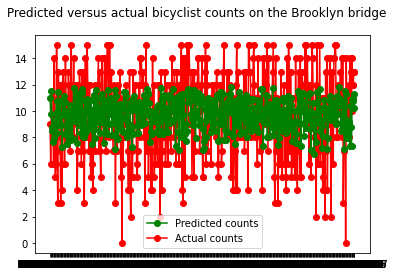

In [46]:
poisson_predictions = ravlt_IR_glm_1.get_prediction(ravlt_IR_x_1)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()

predicted_counts=predictions_summary_frame['mean']
actual_counts = ravlt_IR_y_1['RAVLT Immediate Recall']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
actual, = plt.plot(ravlt_IR_x_1.index, actual_counts, 'ro-', label='Actual counts')
predicted, = plt.plot(ravlt_IR_x_1.index, predicted_counts, 'go-', label='Predicted counts')
plt.legend(handles=[predicted, actual])
plt.show()

<Figure size 432x288 with 0 Axes>

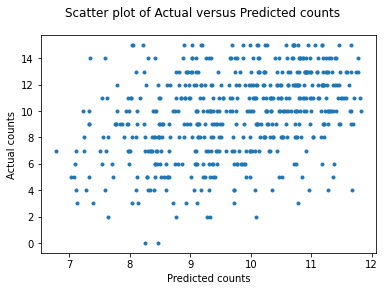

In [47]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

### i-c. NegativeBinomial family - GLM for RAVLT vs. Left PCC:Left AG Connectivity 

In [48]:
# same covariates, multinomial
ravlt_IR_glm_1 = sm.GLM(ravlt_IR_y_1, ravlt_IR_x_1, family=sm.families.NegativeBinomial()).fit()
ravlt_IR_glm_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     RAVLT Immediate Recall   No. Observations:                  518
Model:                                GLM   Df Residuals:                      513
Model Family:            NegativeBinomial   Df Model:                            4
Link Function:                        Log   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1717.7
Date:                    Tue, 01 Nov 2022   Deviance:                       62.469
Time:                            15:18:52   Pearson chi2:                     47.1
No. Iterations:                         5   Pseudo R-squ. (CS):            0.01375
Covariance Type:                nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Left PCC:Left AG Connectivity     0.0638      0.940      0.068      0.946      -1.778       1.906
sex_F                            -0.0125      0.402     -0.031      0.975      -0.801       0.776
age                              -0.0093      0.005     -1.752      0.080      -0.020       0.001
sex*age                           0.0018      0.007      0.269      0.788      -0.012       0.015
const                             2.7367      0.323      8.474      0.000       2.104       3.370
=================================================================================================
"""

## ii. GLM for RAVLT vs. Left PCC:Left AG Connectivity (w/o sex and sex*age)

### ii-a. Gamma family - GLM for RAVLT vs. Left PCC:Left AG Connectivity (w/o sex and sex*age)

In [49]:
cols = ['Left PCC:Left AG Connectivity','age','const']
ravlt_IR_x_1_1 = master_IR_icd_data[cols]
ravlt_IR_y_1_1 = master_IR_icd_data[['RAVLT Immediate Recall']]

ravlt_IR_glm_1_1 = sm.GLM(ravlt_IR_y_1_1, ravlt_IR_x_1_1, family=sm.families.Gamma(sm.families.links.log())).fit()
ravlt_IR_glm_1_1.summary()

/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:777: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1767: RuntimeWarning: invalid value encountered in double_scalars
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     RAVLT Immediate Recall   No. Observations:                  518
Model:                                GLM   Df Residuals:                      515
Model Family:                       Gamma   Df Model:                            2
Link Function:                        log   Scale:                         0.10188
Method:                              IRLS   Log-Likelihood:                    inf
Date:                    Tue, 01 Nov 2022   Deviance:                       201.86
Time:                            15:18:52   Pearson chi2:                     52.5
No. Iterations:                        10   Pseudo R-squ. (CS):                nan
Covariance Type:                nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Left PCC:Left AG Connectivity     0.3287      0.273      1.205      0.228      -0.206       0.863
age                              -0.0082      0.001     -7.981      0.000      -0.010      -0.006
const                             2.7069      0.066     41.071      0.000       2.578       2.836
=================================================================================================
"""

### ii-b. Poisson family - GLM for RAVLT vs. Left PCC:Left AG Connectivity (w/o sex and sex*age)

In [50]:
# same covariates, Posisson
# tutorial for Poisson https://timeseriesreasoning.com/contents/poisson-regression-model/
ravlt_IR_glm_1_1 = sm.GLM(ravlt_IR_y_1_1, ravlt_IR_x_1_1, family=sm.families.Poisson()).fit()
# maybe check other links?
ravlt_IR_glm_1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     RAVLT Immediate Recall   No. Observations:                  518
Model:                                GLM   Df Residuals:                      515
Model Family:                     Poisson   Df Model:                            2
Link Function:                        Log   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1320.0
Date:                    Tue, 01 Nov 2022   Deviance:                       540.39
Time:                            15:18:52   Pearson chi2:                     490.
No. Iterations:                         4   Pseudo R-squ. (CS):             0.1196
Covariance Type:                nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Left PCC:Left AG Connectivity     0.3986      0.271      1.470      0.142      -0.133       0.930
age                              -0.0081      0.001     -7.695      0.000      -0.010      -0.006
const                             2.6981      0.066     40.716      0.000       2.568       2.828
=================================================================================================
"""

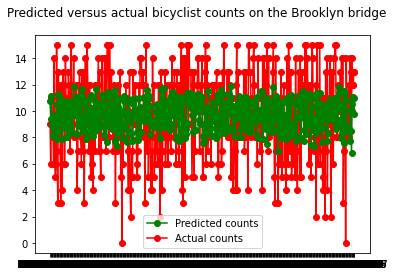

In [51]:
poisson_predictions = ravlt_IR_glm_1_1.get_prediction(ravlt_IR_x_1_1)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()

predicted_counts=predictions_summary_frame['mean']
actual_counts = ravlt_IR_y_1_1['RAVLT Immediate Recall']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
actual, = plt.plot(ravlt_IR_x_1_1.index, actual_counts, 'ro-', label='Actual counts')
predicted, = plt.plot(ravlt_IR_x_1_1.index, predicted_counts, 'go-', label='Predicted counts')
plt.legend(handles=[predicted, actual])
plt.show()

<Figure size 432x288 with 0 Axes>

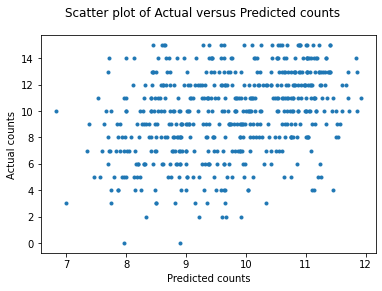

In [52]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

### ii-c. NegativeBinomial family - GLM for RAVLT vs. Left PCC:Left AG Connectivity (w/o sex and sex*age)

In [53]:
# same covariates, multinomial
ravlt_IR_glm_1_1 = sm.GLM(ravlt_IR_y_1_1, ravlt_IR_x_1_1, family=sm.families.NegativeBinomial()).fit()
ravlt_IR_glm_1_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     RAVLT Immediate Recall   No. Observations:                  518
Model:                                GLM   Df Residuals:                      515
Model Family:            NegativeBinomial   Df Model:                            2
Link Function:                        Log   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1718.2
Date:                    Tue, 01 Nov 2022   Deviance:                       63.423
Time:                            15:18:58   Pearson chi2:                     47.3
No. Iterations:                         5   Pseudo R-squ. (CS):            0.01194
Covariance Type:                nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Left PCC:Left AG Connectivity     0.3362      0.897      0.375      0.708      -1.422       2.094
age                              -0.0081      0.003     -2.416      0.016      -0.015      -0.002
const                             2.7059      0.217     12.471      0.000       2.281       3.131
=================================================================================================
"""

## iii. GLM for RAVLT vs. Left PCC:Left PHG Connectivity

### iii-a. Gamma family - GLM for RAVLT vs. Left PCC:Left PHG Connectivity

In [54]:
cols = ['Left PCC:Left PHG Connectivity','sex_F','age','sex*age','const']
ravlt_IR_x_2 = master_IR_icd_data[cols]
ravlt_IR_y_2 = master_IR_icd_data[['RAVLT Immediate Recall']]

ravlt_IR_glm_2 = sm.GLM(ravlt_IR_y_2, ravlt_IR_x_2, family=sm.families.Gamma(sm.families.links.log())).fit()
ravlt_IR_glm_2.summary()

/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:777: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1767: RuntimeWarning: invalid value encountered in double_scalars
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     RAVLT Immediate Recall   No. Observations:                  518
Model:                                GLM   Df Residuals:                      513
Model Family:                       Gamma   Df Model:                            4
Link Function:                        log   Scale:                         0.10170
Method:                              IRLS   Log-Likelihood:                    inf
Date:                    Tue, 01 Nov 2022   Deviance:                       200.74
Time:                            15:18:58   Pearson chi2:                     52.2
No. Iterations:                         8   Pseudo R-squ. (CS):                nan
Covariance Type:                nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Left PCC:Left PHG Connectivity     0.5387      0.563      0.958      0.338      -0.564       1.641
sex_F                             -0.0182      0.122     -0.149      0.881      -0.258       0.221
age                               -0.0092      0.002     -5.776      0.000      -0.012      -0.006
sex*age                            0.0018      0.002      0.875      0.382      -0.002       0.006
const                              2.7296      0.096     28.522      0.000       2.542       2.917
==================================================================================================
"""

### iii-b. Poisson family - GLM for RAVLT vs. Left PCC:Left PHG Connectivity

In [55]:
# same covariates, Posisson
# tutorial for Poisson https://timeseriesreasoning.com/contents/poisson-regression-model/
ravlt_IR_glm_2 = sm.GLM(ravlt_IR_y_2, ravlt_IR_x_2, family=sm.families.Poisson()).fit()
# maybe check other links?
ravlt_IR_glm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     RAVLT Immediate Recall   No. Observations:                  518
Model:                                GLM   Df Residuals:                      513
Model Family:                     Poisson   Df Model:                            4
Link Function:                        Log   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1315.1
Date:                    Tue, 01 Nov 2022   Deviance:                       530.51
Time:                            15:18:58   Pearson chi2:                     484.
No. Iterations:                         4   Pseudo R-squ. (CS):             0.1362
Covariance Type:                nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Left PCC:Left PHG Connectivity     0.5507      0.556      0.991      0.322      -0.538       1.640
sex_F                             -0.0231      0.123     -0.187      0.852      -0.265       0.219
age                               -0.0092      0.002     -5.472      0.000      -0.012      -0.006
sex*age                            0.0019      0.002      0.879      0.379      -0.002       0.006
const                              2.7285      0.098     27.873      0.000       2.537       2.920
==================================================================================================
"""

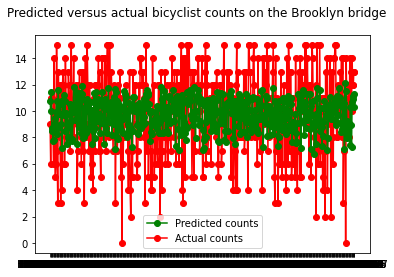

In [56]:
poisson_predictions = ravlt_IR_glm_2.get_prediction(ravlt_IR_x_2)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()

predicted_counts=predictions_summary_frame['mean']
actual_counts = ravlt_IR_y_2['RAVLT Immediate Recall']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
actual, = plt.plot(ravlt_IR_x_2.index, actual_counts, 'ro-', label='Actual counts')
predicted, = plt.plot(ravlt_IR_x_2.index, predicted_counts, 'go-', label='Predicted counts')
plt.legend(handles=[predicted, actual])
plt.show()

<Figure size 432x288 with 0 Axes>

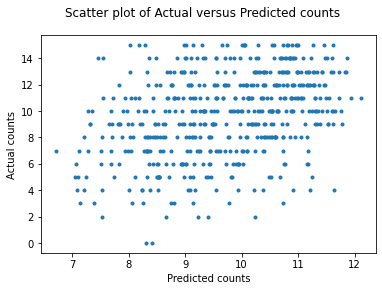

In [57]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

### iii-c. NegativeBinomial family - GLM for RAVLT vs. Left PCC:Left PHG Connectivity 

In [58]:
# same covariates, multinomial
ravlt_IR_glm_2 = sm.GLM(ravlt_IR_y_2, ravlt_IR_x_2, family=sm.families.NegativeBinomial()).fit()
ravlt_IR_glm_2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     RAVLT Immediate Recall   No. Observations:                  518
Model:                                GLM   Df Residuals:                      513
Model Family:            NegativeBinomial   Df Model:                            4
Link Function:                        Log   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1717.7
Date:                    Tue, 01 Nov 2022   Deviance:                       62.388
Time:                            15:19:03   Pearson chi2:                     47.0
No. Iterations:                         4   Pseudo R-squ. (CS):            0.01391
Covariance Type:                nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Left PCC:Left PHG Connectivity     0.5396      1.850      0.292      0.771      -3.087       4.166
sex_F                             -0.0185      0.403     -0.046      0.963      -0.808       0.770
age                               -0.0092      0.005     -1.744      0.081      -0.020       0.001
sex*age                            0.0018      0.007      0.265      0.791      -0.012       0.015
const                              2.7294      0.316      8.641      0.000       2.110       3.348
==================================================================================================
"""

## iv. GLM for RAVLT vs. Left PCC:Left PHG Connectivity (w/o sex and sex*age)

### iv-a. Gamma family - GLM for RAVLT vs. Left PCC:Left PHG Connectivity (w/o sex and sex*age)

In [59]:
cols = ['Left PCC:Left PHG Connectivity','age','const']
ravlt_IR_x_2_1 = master_IR_icd_data[cols]
ravlt_IR_y_2_1 = master_IR_icd_data[['RAVLT Immediate Recall']]

ravlt_IR_glm_2_1 = sm.GLM(ravlt_IR_y_2_1, ravlt_IR_x_2_1, family=sm.families.Gamma(sm.families.links.log())).fit()
ravlt_IR_glm_2_1.summary()

/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:777: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
/Users/sj737/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1767: RuntimeWarning: invalid value encountered in double_scalars
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     RAVLT Immediate Recall   No. Observations:                  518
Model:                                GLM   Df Residuals:                      515
Model Family:                       Gamma   Df Model:                            2
Link Function:                        log   Scale:                         0.10176
Method:                              IRLS   Log-Likelihood:                    inf
Date:                    Tue, 01 Nov 2022   Deviance:                       201.61
Time:                            15:19:03   Pearson chi2:                     52.4
No. Iterations:                         8   Pseudo R-squ. (CS):                nan
Covariance Type:                nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Left PCC:Left PHG Connectivity     1.0587      0.530      1.997      0.046       0.019       2.098
age                               -0.0082      0.001     -8.030      0.000      -0.010      -0.006
const                              2.7071      0.062     43.504      0.000       2.585       2.829
==================================================================================================
"""

### iv-b. Poisson family - GLM for RAVLT vs. Left PCC:Left PHG Connectivity (w/o sex and sex*age)

In [60]:
# same covariates, Posisson
# tutorial for Poisson https://timeseriesreasoning.com/contents/poisson-regression-model/
ravlt_IR_glm_2_1 = sm.GLM(ravlt_IR_y_2_1, ravlt_IR_x_2_1, family=sm.families.Poisson()).fit()
# maybe check other links?
ravlt_IR_glm_2_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     RAVLT Immediate Recall   No. Observations:                  518
Model:                                GLM   Df Residuals:                      515
Model Family:                     Poisson   Df Model:                            2
Link Function:                        Log   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1319.1
Date:                    Tue, 01 Nov 2022   Deviance:                       538.52
Time:                            15:19:03   Pearson chi2:                     489.
No. Iterations:                         4   Pseudo R-squ. (CS):             0.1227
Covariance Type:                nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Left PCC:Left PHG Connectivity     1.0555      0.525      2.012      0.044       0.027       2.084
age                               -0.0081      0.001     -7.737      0.000      -0.010      -0.006
const                              2.7040      0.062     43.265      0.000       2.581       2.826
==================================================================================================
"""

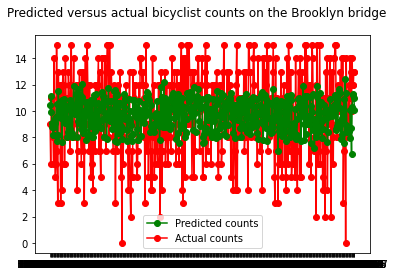

In [61]:
poisson_predictions = ravlt_IR_glm_2_1.get_prediction(ravlt_IR_x_2_1)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()

predicted_counts=predictions_summary_frame['mean']
actual_counts = ravlt_IR_y_2_1['RAVLT Immediate Recall']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
actual, = plt.plot(ravlt_IR_x_2_1.index, actual_counts, 'ro-', label='Actual counts')
predicted, = plt.plot(ravlt_IR_x_2_1.index, predicted_counts, 'go-', label='Predicted counts')
plt.legend(handles=[predicted, actual])
plt.show()

<Figure size 432x288 with 0 Axes>

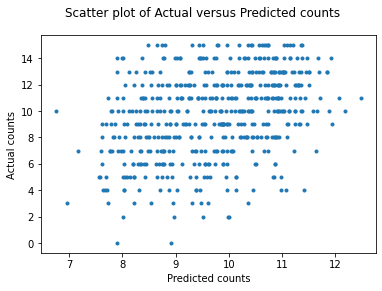

In [62]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

### iv-c. NegativeBinomial family - GLM for RAVLT vs. Left PCC:Left PHG Connectivity (w/o sex and sex*age)

In [63]:
# same covariates, multinomial
ravlt_IR_glm_2_1 = sm.GLM(ravlt_IR_y_2_1, ravlt_IR_x_2_1, family=sm.families.NegativeBinomial()).fit()
ravlt_IR_glm_2_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     RAVLT Immediate Recall   No. Observations:                  518
Model:                                GLM   Df Residuals:                      515
Model Family:            NegativeBinomial   Df Model:                            2
Link Function:                        Log   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1718.1
Date:                    Tue, 01 Nov 2022   Deviance:                       63.194
Time:                            15:19:08   Pearson chi2:                     47.3
No. Iterations:                         4   Pseudo R-squ. (CS):            0.01237
Covariance Type:                nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Left PCC:Left PHG Connectivity     1.0583      1.744      0.607      0.544      -2.360       4.477
age                               -0.0082      0.003     -2.430      0.015      -0.015      -0.002
const                              2.7068      0.205     13.207      0.000       2.305       3.108
==================================================================================================
"""

### Other GLM analyses

In [64]:
# plt.scatter(master_icd_data['RAVLT Sum of Trials 1-5'],master_icd_data['Left PCC:Left AG Connectivity'])

In [65]:
# plt.scatter(master_icd_data['RAVLT Sum of Trials 1-5'],master_icd_data['Left PCC:Left PHG Connectivity'])

In [66]:
# nobs = ravlt_glm_1.nobs
# ytrue = y_1
# yhat = ravlt_glm_1.mu
# fig, ax = plt.subplots()
# ax.scatter(yhat, ytrue)
# line_fit = sm.OLS(ytrue, sm.add_constant(yhat, prepend=True)).fit()
# abline_plot(model_results=line_fit, ax=ax)


# ax.set_title('Model Fit Plot')
# ax.set_ylabel('Observed values')
# ax.set_xlabel('Fitted values');

In [67]:
# rmse(master_icd_data['Left PCC:Left AG Connectivity'], ravlt_glm_1.predict(x_1))

In [68]:
# ravlt_glm_1.aic

In [69]:
# ravlt_glm_1.bic

In [70]:
# ravlt_glm_1.null_deviance

In [71]:
# ravlt_glm_1.deviance

In [72]:
# # F test on the significance of model
# def calculate_nested_f_statistic(small_model, big_model):
#     """Given two fitted GLMs, the larger of which contains the parameter space of the smaller, return the F Stat and P value corresponding to the larger model adding explanatory power"""
#     addtl_params = big_model.df_model - small_model.df_model
#     f_stat = (small_model.deviance - big_model.deviance) / (addtl_params * big_model.scale)
#     df_numerator = addtl_params
#     # use fitted values to obtain n_obs from model object:
#     df_denom = (big_model.fittedvalues.shape[0] - big_model.df_model)
#     p_value = stats.f.sf(f_stat, df_numerator, df_denom)
#     return (f_stat, p_value)

# # Compuyte F statistics of the model 
# big_model = ravlt_glm_1
# # Drop one covariate (column):
# smaller_model = sm.GLM(y_1, x_1['const'], family=sm.families.Gamma(sm.families.links.log())).fit()

# # Using function defined in answer:
# calculate_nested_f_statistic(smaller_model, big_model)

In [73]:
# # compute Rsquare
# sst = sum(map(lambda x_1: np.power(x_1,2),y_1-np.mean(y_1))) 
# sse = sum(map(lambda x_1: np.power(x_1,2),ravlt_glm_1.resid_response)) 
# r2 = 1.0 - sse/sst
# r2

# Age Mediation